In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score

# Set plot style
sns.set_theme(style="whitegrid")

# ==============================================================================
# 1. Load and Preprocess Dataset
# ==============================================================================
filename = "Breast Cancer Wisconsin (Diagnostic)_21.csv"

try:
    df = pd.read_csv(filename)
    print("✅ Dataset loaded successfully.")

    # --- Feature Engineering ---
    # Drop 'id' and 'Unnamed: 32' if they exist
    drop_cols = [col for col in ['id', 'Unnamed: 32'] if col in df.columns]
    df = df.drop(columns=drop_cols)

    # Encode Diagnosis: Malignant (M) -> 1, Benign (B) -> -1
    # SVMs often work better with {-1, 1} labels for the math.
    df['diagnosis'] = df['diagnosis'].map({'M': 1, 'B': -1})

    # Separate features (X) and target (y)
    X = df.drop(columns=['diagnosis']).values
    y = df['diagnosis'].values

    # --- Scaling ---
    # Standardize features to have mean=0 and variance=1.
    # This is CRITICAL for SVMs, especially with polynomial kernels, to prevent
    # features with larger scales from dominating the kernel calculation.
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # --- Train/Test Split ---
    # 80% for training, 20% for testing, stratified by class labels
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    print(f"Features shape: {X.shape}")
    print(f"Training samples: {X_train.shape[0]}")
    print(f"Testing samples:  {X_test.shape[0]}")

except FileNotFoundError:
    print(f"❌ Error: File '{filename}' not found. Please upload it.")
except Exception as e:
    print(f"❌ An error occurred: {e}")

✅ Dataset loaded successfully.
Features shape: (569, 30)
Training samples: 455
Testing samples:  114


In [4]:
# ==============================================================================
# 2. SVM with Polynomial Kernel (From Scratch)
# ==============================================================================
class PolynomialSVM_Scratch:
    def __init__(self, C=1.0, degree=2, c_coef=1.0, lr=0.0001, n_iters=500):
        self.C = C              # Regularization parameter (soft margin)
        self.degree = degree    # Degree of the polynomial
        self.c_coef = c_coef    # Constant term in kernel
        self.lr = lr            # Learning rate for gradient ascent
        self.n_iters = n_iters  # Training iterations
        self.alpha = None       # Dual variables (Lagrange multipliers)
        self.b = 0              # Bias term
        # Store support vectors and their attributes for prediction
        self.sv_X = None
        self.sv_y = None
        self.sv_alpha = None

    def poly_kernel(self, X1, X2):
        """
        Computes the polynomial kernel between two matrices X1 and X2.
        K(X1, X2) = (<X1, X2^T> + c)^d
        """
        return (X1 @ X2.T + self.c_coef) ** self.degree

    def fit(self, X, y):
        n_samples, n_features = X.shape
        # Initialize alphas (dual variables) to zero
        self.alpha = np.zeros(n_samples)

        # Precompute the kernel matrix for all training points
        K = self.poly_kernel(X, X)

        # Gradient Ascent to maximize the Dual Lagrangian
        for i in range(self.n_iters):
            # Gradient w.r.t alpha = 1 - y * (K @ (alpha * y))
            gradient = 1 - y * (K @ (self.alpha * y))
            self.alpha += self.lr * gradient

            # Project alphas back to the feasible set [0, C] (Box constraints)
            self.alpha = np.clip(self.alpha, 0, self.C)
            
            # Optional: Print progress occasionally
            if (i + 1) % 100 == 0:
                 # Simple objective function tracking could go here
                 pass

        # Identify Support Vectors (where alpha > 0)
        # Use a small threshold to filter out numerical noise close to 0
        sv_mask = self.alpha > 1e-5
        self.sv_X = X[sv_mask]
        self.sv_y = y[sv_mask]
        self.sv_alpha = self.alpha[sv_mask]

        # Calculate bias term 'b'
        # For any support vector on the margin (0 < alpha < C):
        # y_k(sum(alpha_i * y_i * K(x_i, x_k)) + b) = 1
        # -> b = y_k - sum(alpha_i * y_i * K(x_i, x_k))
        # We average this over all such support vectors for stability.
        if len(self.sv_alpha) > 0:
            K_sv = self.poly_kernel(self.sv_X, self.sv_X)
            # Compute b for all SVs and take the mean
            b_values = self.sv_y - (K_sv @ (self.sv_alpha * self.sv_y))
            self.b = np.mean(b_values)
        else:
            self.b = 0

    def decision_function(self, X):
        """Computes the raw score (distance from hyperplane) for samples in X."""
        if self.sv_X is None:
             return np.zeros(X.shape[0])
        # K(X, SVs)
        K_x_sv = self.poly_kernel(X, self.sv_X)
        # f(x) = sum(alpha_i * y_i * K(x_i, x)) + b
        return (K_x_sv @ (self.sv_alpha * self.sv_y)) + self.b

    def predict(self, X):
        """Returns class labels {-1, 1} based on the sign of the decision function."""
        return np.sign(self.decision_function(X))

print("✅ PolynomialSVM_Scratch class defined successfully.")

✅ PolynomialSVM_Scratch class defined successfully.


In [5]:
if 'X_train' in locals():
    print("Starting training...")
    # Initialize model with a quadratic kernel (degree=2)
    # You might need to tune C, lr, and n_iters for optimal convergence.
    svm = PolynomialSVM_Scratch(C=1.0, degree=2, c_coef=1.0, lr=0.001, n_iters=1000)
    
    svm.fit(X_train, y_train)
    
    print("Training complete.")
    print(f"Found {len(svm.sv_alpha)} support vectors.")

Starting training...
Training complete.
Found 285 support vectors.


Test Accuracy: 0.4123


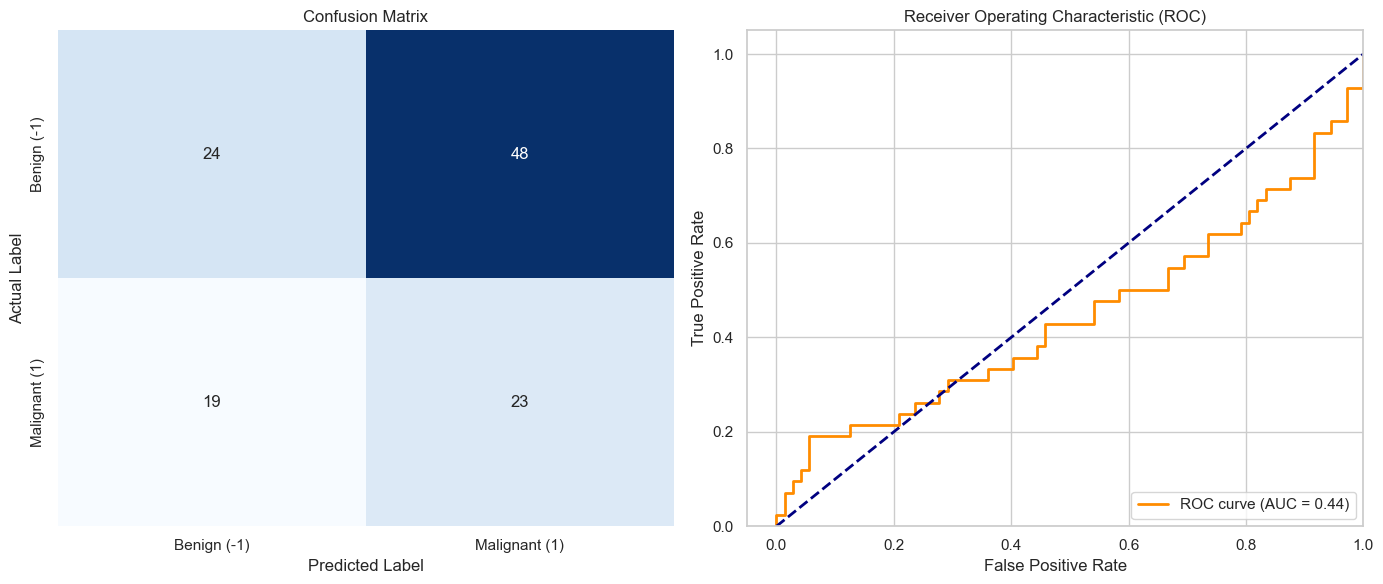

In [6]:
if 'svm' in locals():
    # Get predictions and raw scores for evaluation
    y_pred = svm.predict(X_test)
    y_scores = svm.decision_function(X_test)

    # --- Metrics ---
    acc = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    fpr, tpr, _ = roc_curve(y_test, y_scores)
    roc_auc = auc(fpr, tpr)

    print(f"Test Accuracy: {acc:.4f}")

    # --- Plotting ---
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))

    # 1. Confusion Matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax[0], cbar=False,
                xticklabels=['Benign (-1)', 'Malignant (1)'],
                yticklabels=['Benign (-1)', 'Malignant (1)'])
    ax[0].set_title('Confusion Matrix')
    ax[0].set_xlabel('Predicted Label')
    ax[0].set_ylabel('Actual Label')

    # 2. ROC Curve
    ax[1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    ax[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax[1].set_xlim([-0.05, 1.0])
    ax[1].set_ylim([0.0, 1.05])
    ax[1].set_xlabel('False Positive Rate')
    ax[1].set_ylabel('True Positive Rate')
    ax[1].set_title('Receiver Operating Characteristic (ROC)')
    ax[1].legend(loc="lower right")

    plt.tight_layout()
    plt.show()